In [1]:
!pip install "numpy<2"

In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate


from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import ndcg_score

from surprise.model_selection import GridSearchCV

# Reading Files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_path = "/content/drive/MyDrive/BPP takehome assignment"

In [5]:
user_df = pd.read_csv(os.path.join(base_path, 'users.csv'))
user_df.head()

,user_id,title,department,seniority_level,learning_style
0,1,Fresher (Business Analyst),Data,Fresher,Auditory
1,2,Junior Software Engineer,Engineering,Junior,Reading/Writing
2,3,Fresher (Marketing Associate),Marketing,Fresher,Reading/Writing
3,4,Fresher (Business Analyst),Data,Fresher,Reading/Writing
4,5,Fresher (Data Analyst),Data,Fresher,Auditory


In [6]:
content_df = pd.read_csv(os.path.join(base_path, 'content.csv'))
content_df.head()

,content_id,title,domain,subtopic,difficulty_level,content_type
0,1,Proactive mobile moratorium,Marketing,social-media-analytics,Beginner,Video
1,2,Assimilated systemic benchmark,Design,linear-algebra,Beginner,Video
2,3,Balanced tangible policy,Data Science,sql,Beginner,Article
3,4,Centralized disintermediate framework,Mathematics,social-media-analytics,Intermediate,Video
4,5,Focused actuating neural-net,Finance,financial-modeling,Advanced,Video


In [7]:
engagements_df = pd.read_csv(os.path.join(base_path, 'engagements.csv'),parse_dates=[2])
engagements_df.head()

,user_id,content_id,timestamp,duration_seconds,liked,engagement_type
0,26543,6690,2024-10-18 08:59:18.029428,832,NaN,viewed
1,10942,8194,2025-04-10 23:10:05.029428,926,NaN,viewed
2,64854,1910,2025-04-08 09:17:59.029428,510,1.0,viewed
3,1864,7857,2025-05-11 08:38:32.029428,1094,NaN,viewed
4,24645,3814,2024-12-22 03:19:06.029428,1180,NaN,viewed


In [8]:
engagements_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int64         
 1   content_id        int64         
 2   timestamp         datetime64[ns]
 3   duration_seconds  int64         
 4   liked             float64       
 5   engagement_type   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.3+ MB


# EDA

In [9]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          100000 non-null  int64 
 1   title            100000 non-null  object
 2   department       100000 non-null  object
 3   seniority_level  100000 non-null  object
 4   learning_style   100000 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [10]:
user_df.isna().sum()

,0
user_id,0
title,0
department,0
seniority_level,0
learning_style,0


In [11]:
categorical_cols = user_df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"Column: {col}")
    print(user_df[col].nunique(), user_df[col].value_counts(normalize=True) * 100)
    print("-"*50)

Column: title
30 title
Student (Data Science)              12.642
Student (Software Engineering)       8.372
Fresher (Junior Developer)           8.343
Fresher (Data Analyst)               8.295
Student (Marketing)                  8.278
Student (Business Analyst)           8.267
Junior Business Analyst              4.269
Fresher (Business Analyst)           4.257
Junior Software Engineer             4.241
Fresher (Marketing Associate)        4.141
Junior Machine Learning Engineer     4.098
Junior Data Scientist                4.094
Junior Data Analyst                  4.073
Marketing Assistant                  2.529
Data Scientist                       1.650
Software Engineer                    1.646
Data Analyst                         1.617
Senior Software Engineer             0.868
Product Manager                      0.856
Senior Product Manager               0.854
Business Intelligence Analyst        0.853
Senior Data Analyst                  0.842
Marketing Manager              

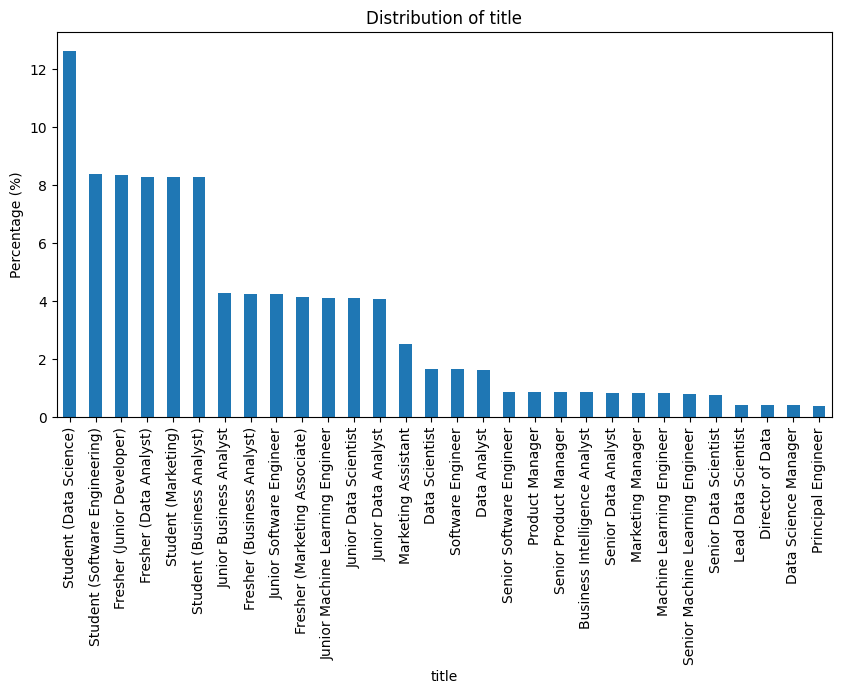

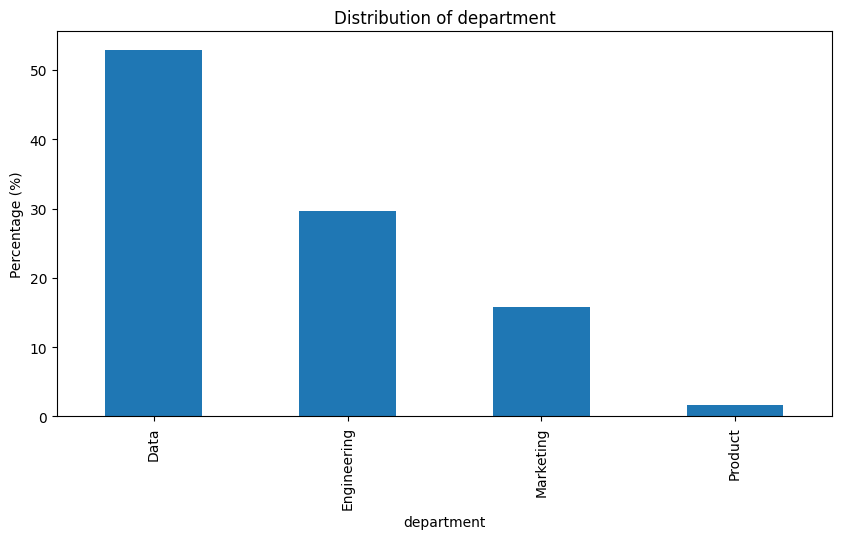

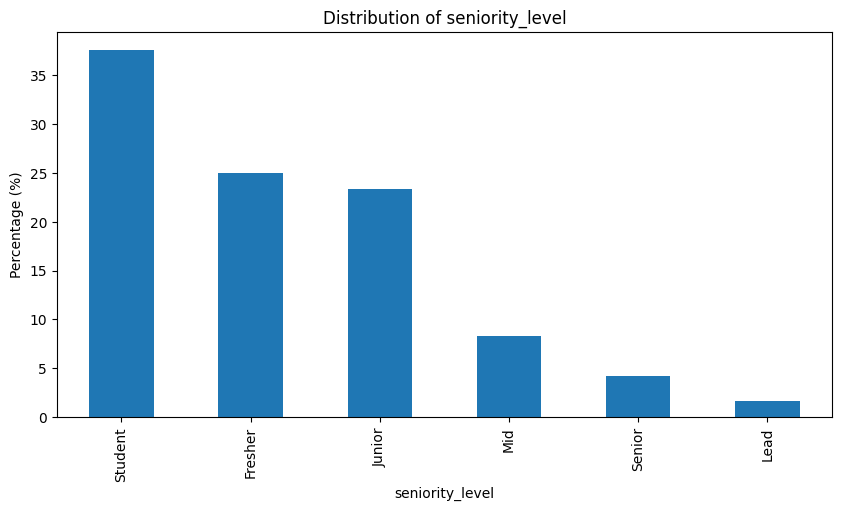

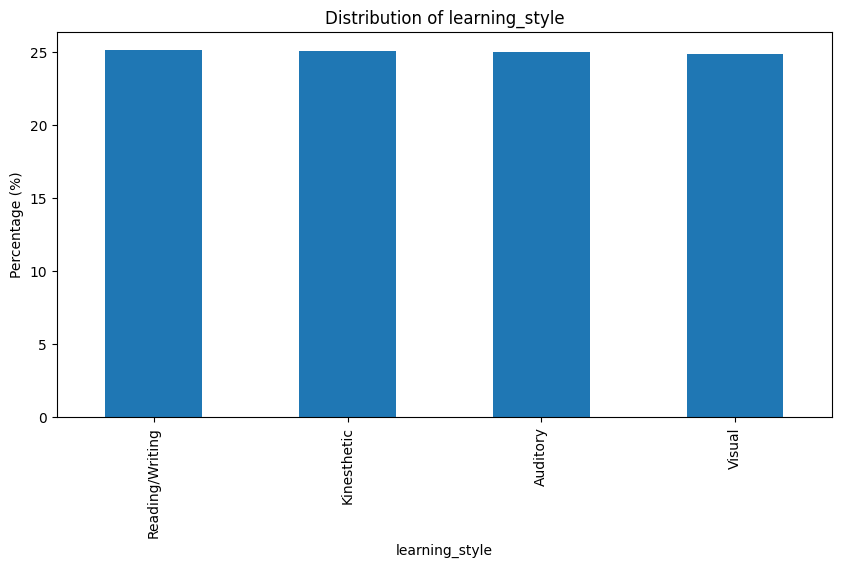

In [12]:
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    user_df[col].value_counts(normalize=True).mul(100).plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.ylabel("Percentage (%)")
    plt.xlabel(col)
    plt.show()

In [13]:
# title vs department
title_dept = pd.crosstab(user_df['title'], user_df['department'], normalize='index').mul(100)
print("\nTitle vs Department (%):\n", title_dept.head(10))  # show top 10

# seniority vs department
seniority_dept = pd.crosstab(user_df['seniority_level'], user_df['department'], normalize='index').mul(100)
print("\nSeniority vs Department (%):\n", seniority_dept)

# seniority vs learning style
seniority_learning = pd.crosstab(user_df['seniority_level'], user_df['learning_style'], normalize='index').mul(100)
print("\nSeniority vs Learning Style (%):\n", seniority_learning)


Title vs Department (%):
 department                      Data  Engineering  Marketing  Product
title                                                                
Business Intelligence Analyst  100.0          0.0        0.0      0.0
Data Analyst                   100.0          0.0        0.0      0.0
Data Science Manager           100.0          0.0        0.0      0.0
Data Scientist                 100.0          0.0        0.0      0.0
Director of Data               100.0          0.0        0.0      0.0
Fresher (Business Analyst)     100.0          0.0        0.0      0.0
Fresher (Data Analyst)         100.0          0.0        0.0      0.0
Fresher (Junior Developer)       0.0        100.0        0.0      0.0
Fresher (Marketing Associate)    0.0          0.0      100.0      0.0
Junior Business Analyst        100.0          0.0        0.0      0.0

Seniority vs Department (%):
 department            Data  Engineering  Marketing    Product
seniority_level                         

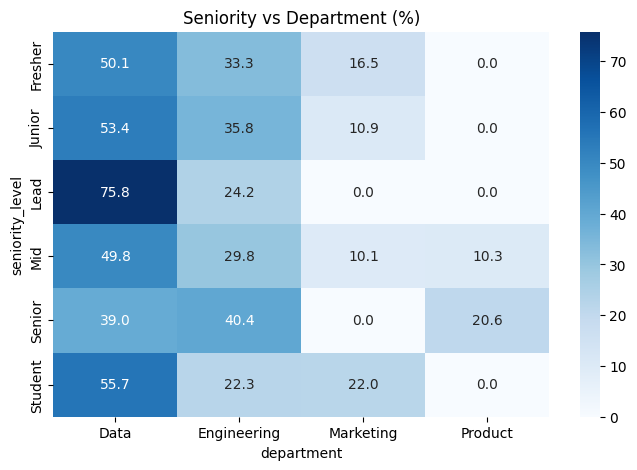

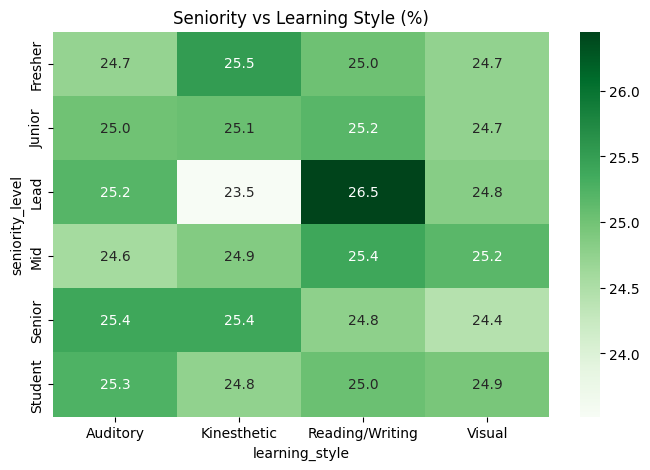

In [14]:
plt.figure(figsize=(8,5))
sns.heatmap(seniority_dept, annot=True, fmt=".1f", cmap="Blues")
plt.title("Seniority vs Department (%)")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(seniority_learning, annot=True, fmt=".1f", cmap="Greens")
plt.title("Seniority vs Learning Style (%)")
plt.show()

- `title` and `department` are strongly correlated → avoid using both (feature redundancy).
- Seniority influences domain preference → senior/lead roles lean toward **Data/Product**, juniors toward Marketing.
- Learning style is consistent → better used as a _personalized filter_, not for clustering roles.

In [15]:
user_df[user_df.duplicated()].shape

(0, 5)

In [16]:
user_df['title_clean'] = user_df['title'].str.lower().str.strip()
user_df[user_df.duplicated()].shape

(0, 6)

- No exact duplicates, but semantic overlaps present (same title across different experience levels)

In [17]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   content_id        10000 non-null  int64 
 1   title             10000 non-null  object
 2   domain            10000 non-null  object
 3   subtopic          10000 non-null  object
 4   difficulty_level  10000 non-null  object
 5   content_type      10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [18]:
content_df.isna().sum()

,0
content_id,0
title,0
domain,0
subtopic,0
difficulty_level,0
content_type,0


In [19]:
categorical_cols = content_df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"Column: {col}")
    print(content_df[col].nunique(), content_df[col].value_counts(normalize=True) * 100)
    print("-"*50)

Column: title
9957 title
Multi-layered 4thgeneration application    0.02
Front-line 3rdgeneration time-frame        0.02
Enterprise-wide global application         0.02
Integrated global task-force               0.02
Mandatory homogeneous task-force           0.02
                                           ... 
Sharable attitude-oriented hardware        0.01
Multi-lateral executive intranet           0.01
Mandatory bi-directional model             0.01
Polarized bifurcated middleware            0.01
Distributed 5thgeneration database         0.01
Name: proportion, Length: 9957, dtype: float64
--------------------------------------------------
Column: domain
7 domain
Marketing               15.10
Data Science            14.88
Business                14.24
Finance                 14.16
Mathematics             14.00
Software Engineering    13.90
Design                  13.72
Name: proportion, dtype: float64
--------------------------------------------------
Column: subtopic
9 subtopic
agi

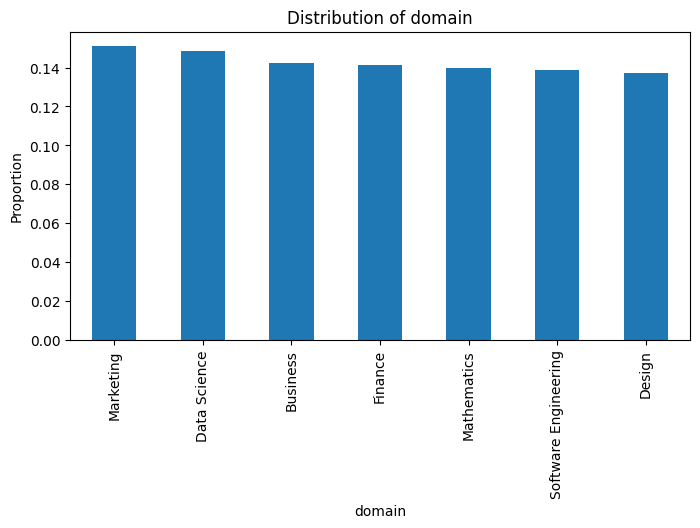

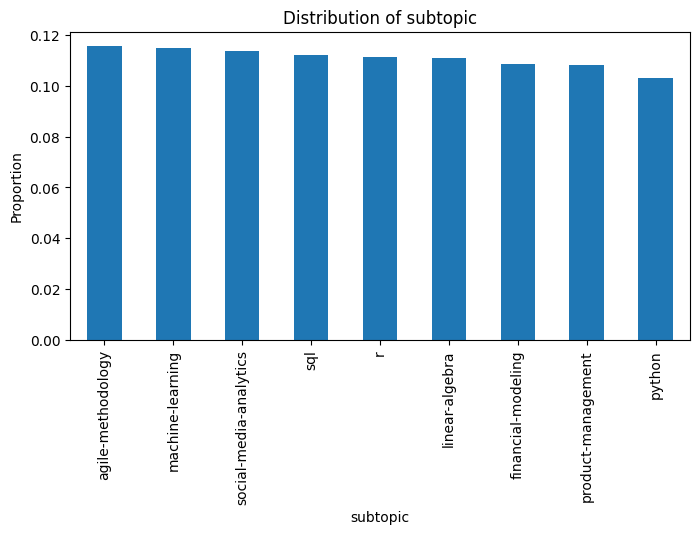

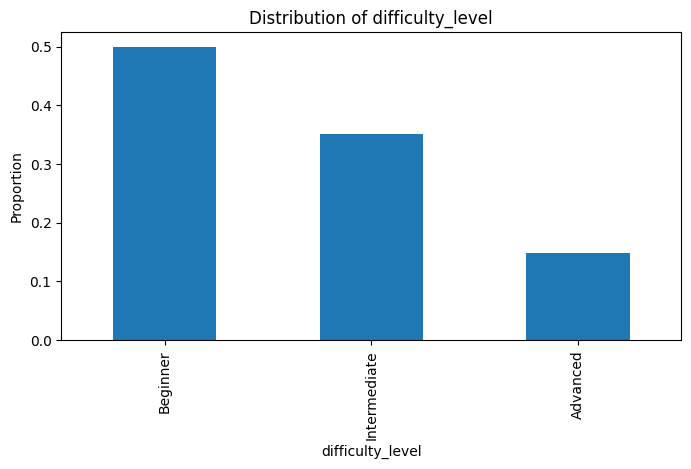

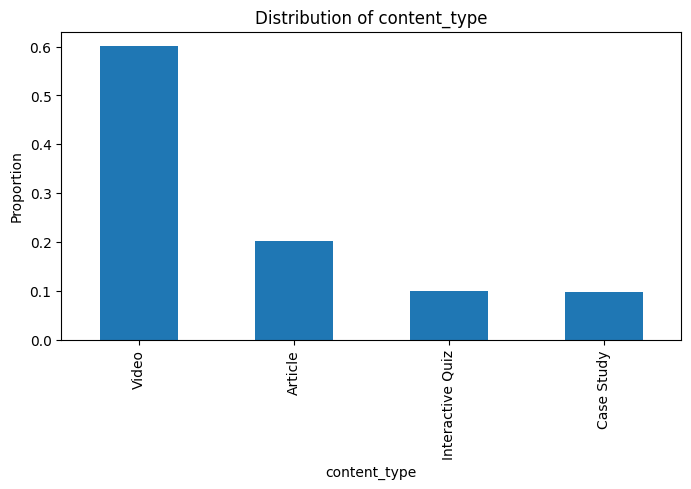

In [20]:
for col in ["domain", "subtopic", "difficulty_level", "content_type"]:
    plt.figure(figsize=(8,4))
    content_df[col].value_counts(normalize=True).sort_values(ascending=False).plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.ylabel("Proportion")
    plt.show()

In [21]:
# cross-tab
print("Unique Titles:", content_df["title"].nunique())
print("Top 10 Titles:\n", content_df["title"].value_counts().head(10))

Unique Titles: 9957
Top 10 Titles:
 title
Multi-layered 4thgeneration application     2
Front-line 3rdgeneration time-frame         2
Enterprise-wide global application          2
Integrated global task-force                2
Mandatory homogeneous task-force            2
Enhanced multi-tasking open system          2
Assimilated bandwidth-monitored capacity    2
Profound heuristic ability                  2
Persevering 6thgeneration firmware          2
Distributed dynamic archive                 2
Name: count, dtype: int64


difficulty_level       Advanced   Beginner  Intermediate
domain                                                  
Business              15.941011  49.016854     35.042135
Data Science          14.986559  50.201613     34.811828
Design                13.994169  48.177843     37.827988
Finance               14.124294  51.624294     34.251412
Marketing             13.708609  51.456954     34.834437
Mathematics           14.071429  51.071429     34.857143
Software Engineering  17.194245  48.129496     34.676259


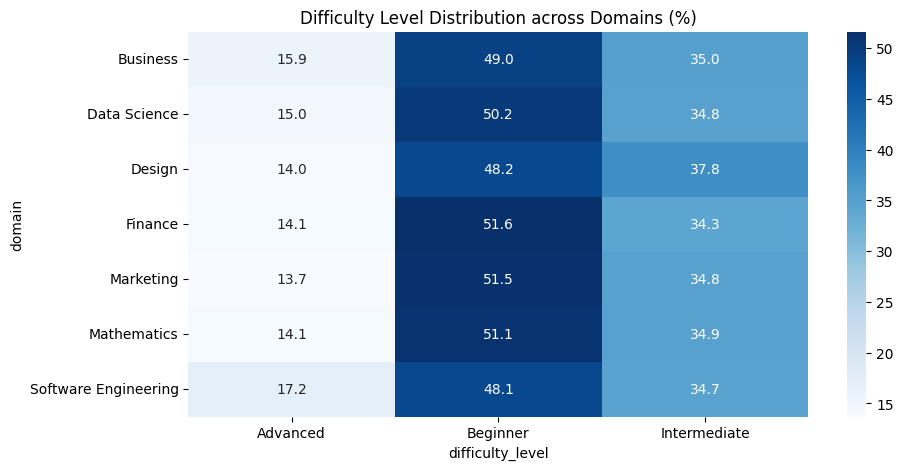

content_type            Article  Case Study  Interactive Quiz      Video
domain                                                                  
Business              20.014045   10.042135          9.269663  60.674157
Data Science          19.220430    9.206989         11.357527  60.215054
Design                21.137026    9.985423          9.475219  59.402332
Finance               21.186441    9.533898         10.593220  58.686441
Marketing             19.867550   10.066225         10.728477  59.337748
Mathematics           19.642857    9.714286          9.500000  61.142857
Software Engineering  20.647482    9.352518          8.992806  61.007194


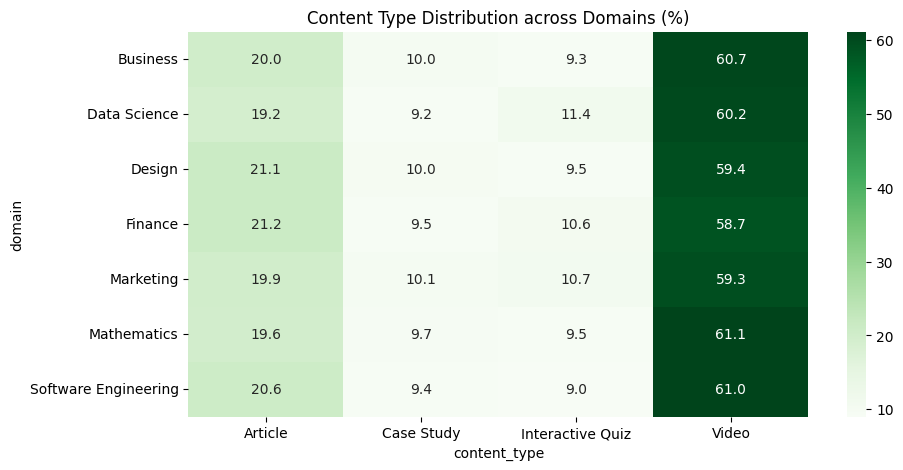

In [22]:
# Difficulty vs Domain
diff_domain = pd.crosstab(content_df["domain"], content_df["difficulty_level"], normalize="index") * 100
print(diff_domain)

plt.figure(figsize=(10,5))
sns.heatmap(diff_domain, annot=True, fmt=".1f", cmap="Blues")
plt.title("Difficulty Level Distribution across Domains (%)")
plt.show()

# Content Type vs Domain
ctype_domain = pd.crosstab(content_df["domain"], content_df["content_type"], normalize="index") * 100
print(ctype_domain)

plt.figure(figsize=(10,5))
sns.heatmap(ctype_domain, annot=True, fmt=".1f", cmap="Greens")
plt.title("Content Type Distribution across Domains (%)")
plt.show()

- Content is skewed toward beginner + video lessons → must handle imbalance in recommendation.
- Advanced learners may have fewer lessons.
- Interactive content is limited → could be used as a `high-value` recommendation for engagement.
- Domain patterns are subtle, but slightly more quizzes in Data Science and more advanced content in Software Engineering.

In [23]:
engagements_df.isna().sum()

,0
user_id,0
content_id,0
timestamp,0
duration_seconds,0
liked,2100556
engagement_type,0


In [24]:
engagements_df.shape

(3000000, 6)

In [25]:
# General interaction distribution

print("Total interactions:", len(engagements_df.drop_duplicates()))
print("Unique users:", engagements_df["user_id"].nunique())
print("Unique content:", engagements_df["content_id"].nunique())

Total interactions: 3000000
Unique users: 87267
Unique content: 9917


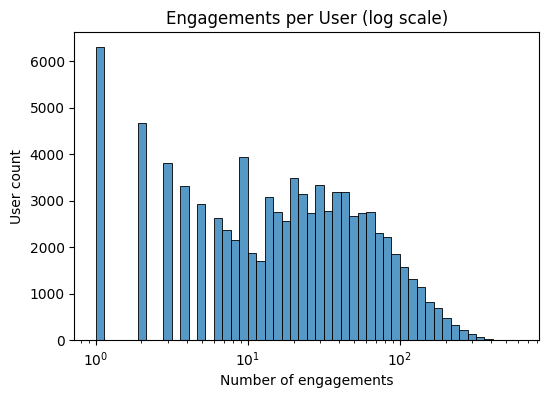

In [26]:
# Engagements per user
user_engagements = engagements_df["user_id"].value_counts()
plt.figure(figsize=(6,4))
sns.histplot(user_engagements, bins=50, log_scale=True)
plt.title("Engagements per User (log scale)")
plt.xlabel("Number of engagements")
plt.ylabel("User count")
plt.show()

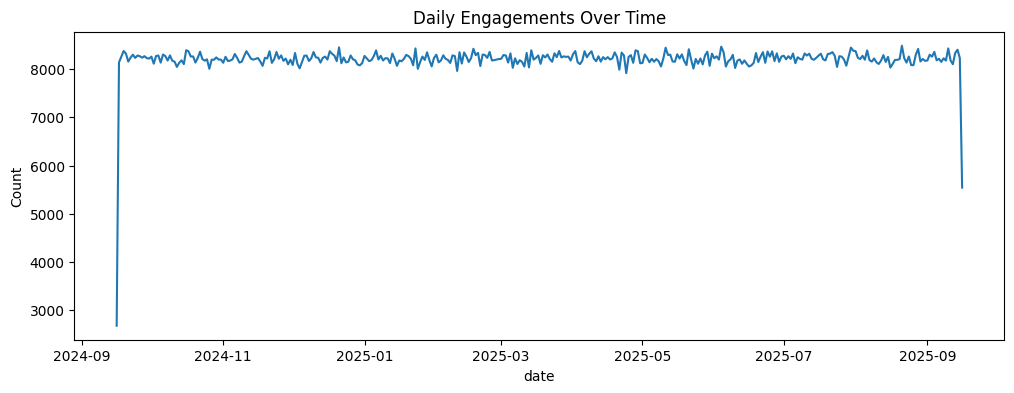

/tmp/ipython-input-2560582177.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="hour", data=engagements_df, palette="Blues")


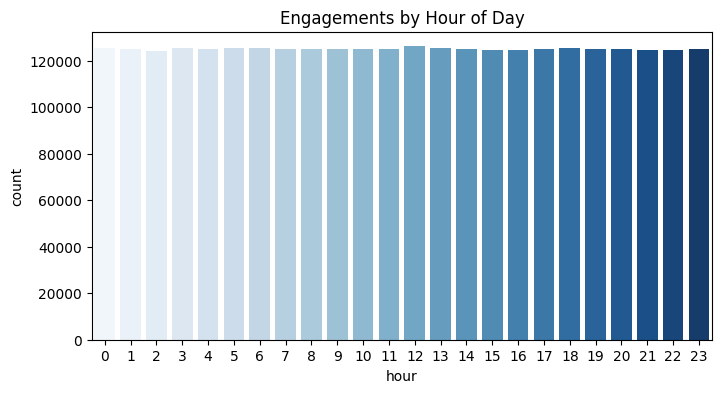

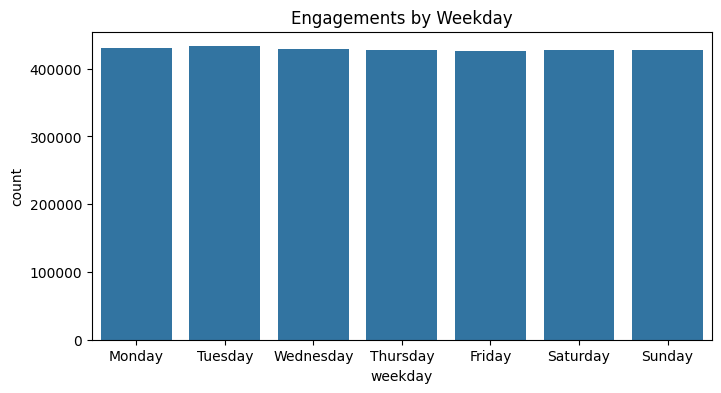

In [27]:
#Time-based analysis

engagements_df["date"] = engagements_df["timestamp"].dt.date
engagements_df["hour"] = engagements_df["timestamp"].dt.hour
engagements_df["weekday"] = engagements_df["timestamp"].dt.day_name()

# Daily activity
daily_counts = engagements_df.groupby("date").size()
plt.figure(figsize=(12,4))
daily_counts.plot()
plt.title("Daily Engagements Over Time")
plt.ylabel("Count")
plt.show()

# Hour of day
plt.figure(figsize=(8,4))
sns.countplot(x="hour", data=engagements_df, palette="Blues")
plt.title("Engagements by Hour of Day")
plt.show()

# Weekday
plt.figure(figsize=(8,4))
sns.countplot(x="weekday", data=engagements_df, order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Engagements by Weekday")
plt.show()


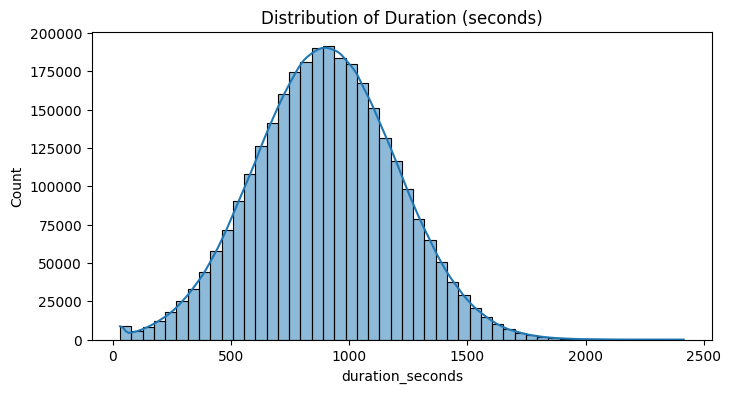

Average duration by engagement type:
 engagement_type
bookmarked    899.762428
completed     899.257769
shared        899.208302
viewed        899.791156
Name: duration_seconds, dtype: float64


In [28]:
#Duration analysis

plt.figure(figsize=(8,4))
sns.histplot(engagements_df["duration_seconds"], bins=50, kde=True)
plt.title("Distribution of Duration (seconds)")
plt.show()

# Average duration per engagement type
avg_duration_by_type = engagements_df.groupby("engagement_type")["duration_seconds"].mean()
print("Average duration by engagement type:\n", avg_duration_by_type)

In [29]:
#Feedback signals
print("Liked distribution:\n", engagements_df["liked"].value_counts(dropna=False))

Liked distribution:
 liked
NaN    2100556
1.0     899444
Name: count, dtype: int64


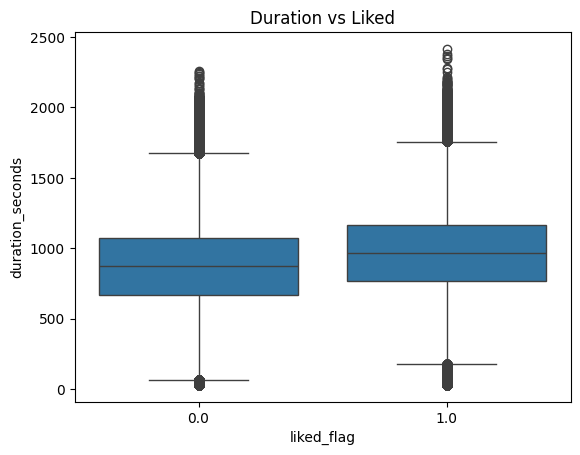

In [30]:
# Probability of like given duration
engagements_df["liked_flag"] = engagements_df["liked"].fillna(0)
sns.boxplot(x="liked_flag", y="duration_seconds", data=engagements_df)
plt.title("Duration vs Liked")
plt.show()

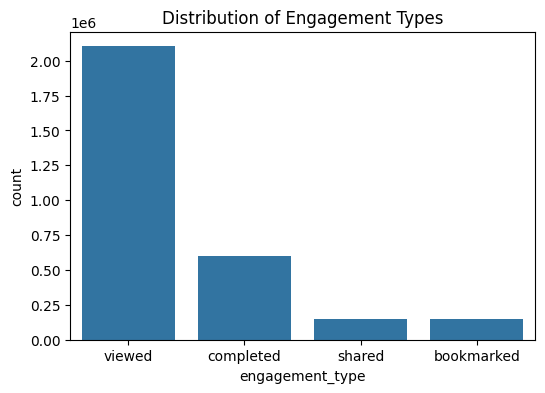

In [31]:
#Engagement type analysis

plt.figure(figsize=(6,4))
sns.countplot(x="engagement_type", data=engagements_df)
plt.title("Distribution of Engagement Types")
plt.show()

Engagement Type vs Like (%):
 liked_flag             0.0        1.0
engagement_type                      
bookmarked       70.076544  29.923456
completed        70.097723  29.902277
shared           70.061051  29.938949
viewed           69.988826  30.011174


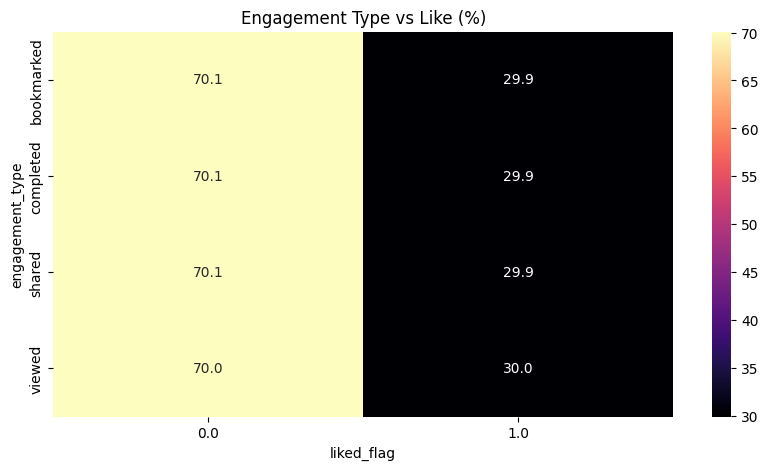

In [32]:
# engagement_type vs liked
etype_liked = pd.crosstab(engagements_df["engagement_type"], engagements_df["liked_flag"], normalize="index") * 100
print("Engagement Type vs Like (%):\n", etype_liked)

plt.figure(figsize=(10,5))
sns.heatmap(etype_liked, annot=True, fmt=".1f", cmap="magma")
plt.title("Engagement Type vs Like (%)")
plt.show()

Correlation between duration and like:
                   duration_seconds  liked_flag
duration_seconds          1.000000    0.146227
liked_flag                0.146227    1.000000


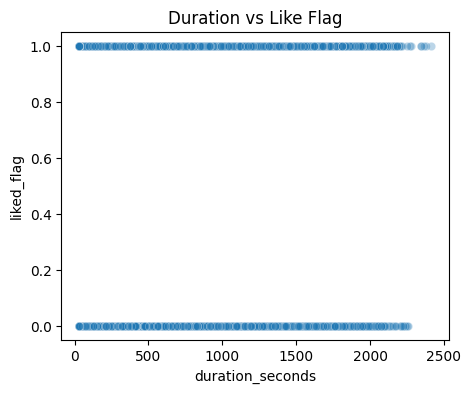

In [33]:
#Correlations

corr_val = engagements_df[["duration_seconds","liked_flag"]].corr()
print("Correlation between duration and like:\n", corr_val)

plt.figure(figsize=(5,4))
sns.scatterplot(x="duration_seconds", y="liked_flag", data=engagements_df, alpha=0.3)
plt.title("Duration vs Like Flag")
plt.show()

- User Engagement: Most users are casual (1–5 engagements); few are power users (100+). **Need to focus on retention.**

- Content Engagement: Most content gets 100–1000 interactions; top content drives trends and insights.

- Daily Activity: Stable ~8k engagements/day; platform reliable but growth flat.

- Engagement Types: Viewed dominates (~70%), smaller subsets (completed, shared, bookmarked) indicating higher commitment.

- Likes & Duration: \~30% of interactions are liked; liked sessions slightly longer (~16 mins vs 14.5).

In [34]:
engagements_user_df = engagements_df.merge(user_df, on="user_id", how="left")

# Merge the above with content
df = engagements_user_df.merge(content_df, on="content_id", how="left")

# Check the shape
print(df.shape)
print(df.head())


(3000000, 20)
   user_id  content_id                  timestamp  duration_seconds  liked  \
0    26543        6690 2024-10-18 08:59:18.029428               832    NaN   
1    10942        8194 2025-04-10 23:10:05.029428               926    NaN   
2    64854        1910 2025-04-08 09:17:59.029428               510    1.0   
3     1864        7857 2025-05-11 08:38:32.029428              1094    NaN   
4    24645        3814 2024-12-22 03:19:06.029428              1180    NaN   

  engagement_type        date  hour   weekday  liked_flag  \
0          viewed  2024-10-18     8    Friday         0.0   
1          viewed  2025-04-10    23  Thursday         0.0   
2          viewed  2025-04-08     9   Tuesday         1.0   
3          viewed  2025-05-11     8    Sunday         0.0   
4          viewed  2024-12-22     3    Sunday         0.0   

                         title_x department seniority_level   learning_style  \
0         Fresher (Data Analyst)       Data         Fresher      Kines

In [35]:
user_df.shape, engagements_df.shape, content_df.shape

((100000, 6), (3000000, 10), (10000, 6))

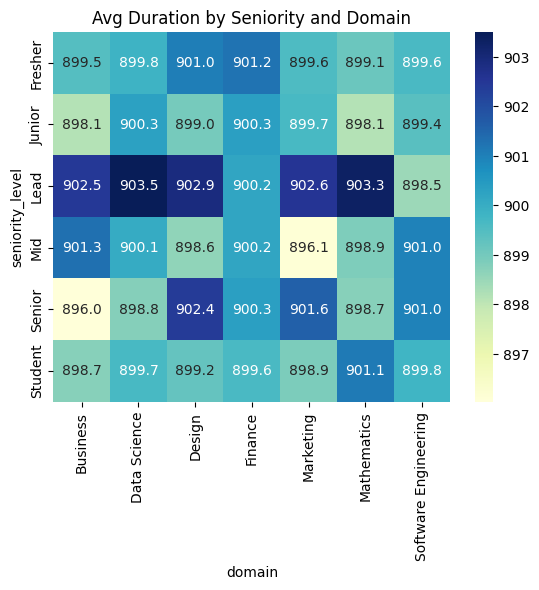

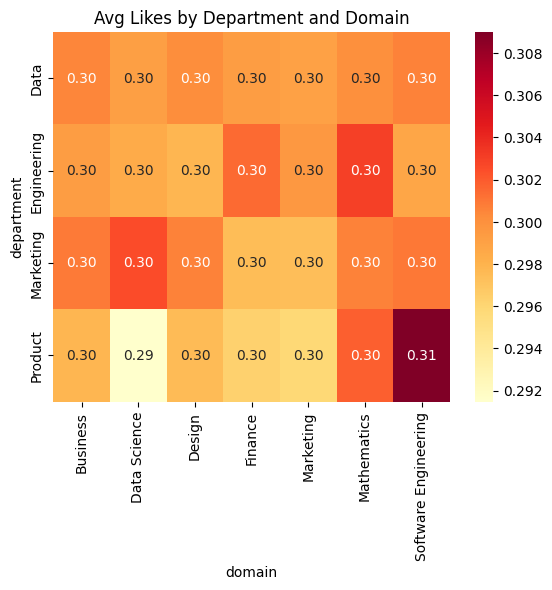

In [36]:
# average duration by seniority and domain
pivot = df.pivot_table(values="duration_seconds", index="seniority_level", columns="domain", aggfunc="mean")
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Avg Duration by Seniority and Domain")
plt.show()

#  liked_flag by department and domain
pivot_likes = df.pivot_table(values="liked_flag", index="department", columns="domain", aggfunc="mean")
sns.heatmap(pivot_likes, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Avg Likes by Department and Domain")
plt.show()

- Like probability and session duration are relatively stable across **departments, domains, and seniority levels**.

- Slightly higher likes in **Marketing/Engineering** domains and longer sessions for **Leads** could guide targeted engagement strategies.

- Overall, user engagement behavior is consistent, indicating broad content appeal across roles and domains.

# Feature Engineering

In [37]:
# Ordinal encode seniority_level
seniority_mapping = { "Student": 0, "Fresher": 1, "Junior": 2, "Mid": 3, "Senior": 4, "Lead": 5}
df["seniority_encoded"] = df["seniority_level"].map(seniority_mapping)

# One - hot encoding department
department_dummies = pd.get_dummies(df["department"], prefix="dept")
df = pd.concat([df, department_dummies], axis=1)

# One - hot encode learning_style
learning_style_dummies = pd.get_dummies(df["learning_style"], prefix="style")
df = pd.concat([df, learning_style_dummies], axis=1)

# Combine seniority & department into a single feature
df["seniority_department"] = df["seniority_level"] + "_" + df["department"]

print(df.head())

   user_id  content_id                  timestamp  duration_seconds  liked  \
0    26543        6690 2024-10-18 08:59:18.029428               832    NaN   
1    10942        8194 2025-04-10 23:10:05.029428               926    NaN   
2    64854        1910 2025-04-08 09:17:59.029428               510    1.0   
3     1864        7857 2025-05-11 08:38:32.029428              1094    NaN   
4    24645        3814 2024-12-22 03:19:06.029428              1180    NaN   

  engagement_type        date  hour   weekday  liked_flag  ...  \
0          viewed  2024-10-18     8    Friday         0.0  ...   
1          viewed  2025-04-10    23  Thursday         0.0  ...   
2          viewed  2025-04-08     9   Tuesday         1.0  ...   
3          viewed  2025-05-11     8    Sunday         0.0  ...   
4          viewed  2024-12-22     3    Sunday         0.0  ...   

  seniority_encoded dept_Data dept_Engineering dept_Marketing dept_Product  \
0                 1      True            False          

In [38]:
# Compute user-level engagement features
user_stats = df.groupby("user_id").agg(
    user_engagement_count=("content_id", "count"),         # Total engagements
    user_avg_duration=("duration_seconds", "mean"),        # Average duration per engagement
    user_like_ratio=("liked_flag", "mean"),                # Like ratio
    user_unique_domains=("domain", "nunique")
).reset_index()
df = df.merge(user_stats, on="user_id", how="left")

# Content-level features
content_stats = df.groupby("content_id").agg(
    content_engagement_count=("user_id", "count"),
    content_avg_duration=("duration_seconds", "mean"),
    content_like_ratio=("liked_flag", "mean")
).reset_index()
df = df.merge(content_stats, on="content_id", how="left")

# seniority × domain average duration
sen_dom = df.groupby(["seniority_level","domain"])["duration_seconds"].mean().reset_index()
sen_dom = sen_dom.rename(columns={"duration_seconds":"sen_dom_avg_duration"})
df = df.merge(sen_dom, on=["seniority_level","domain"], how="left")

In [39]:
df.head()

,user_id,content_id,timestamp,duration_seconds,liked,engagement_type,date,hour,weekday,liked_flag,...,style_Visual,seniority_department,user_engagement_count,user_avg_duration,user_like_ratio,user_unique_domains,content_engagement_count,content_avg_duration,content_like_ratio,sen_dom_avg_duration
0,26543,6690,2024-10-18 08:59:18.029428,832,NaN,viewed,2024-10-18,8,Friday,0.0,...,False,Fresher_Data,182,898.807692,0.318681,7,305,909.527869,0.259016,901.036647
1,10942,8194,2025-04-10 23:10:05.029428,926,NaN,viewed,2025-04-10,23,Thursday,0.0,...,False,Senior_Product,139,912.589928,0.258993,7,692,898.028902,0.294798,900.971424
2,64854,1910,2025-04-08 09:17:59.029428,510,1.0,viewed,2025-04-08,9,Tuesday,1.0,...,False,Senior_Data,74,871.905405,0.310811,7,1677,901.115086,0.298151,901.588162
3,1864,7857,2025-05-11 08:38:32.029428,1094,NaN,viewed,2025-05-11,8,Sunday,0.0,...,True,Fresher_Data,83,960.831325,0.421687,7,455,885.254945,0.290110,899.836127
4,24645,3814,2024-12-22 03:19:06.029428,1180,NaN,viewed,2024-12-22,3,Sunday,0.0,...,False,Fresher_Marketing,136,916.816176,0.301471,7,413,901.922518,0.319613,899.457391


## create embeddings and user profiles

In [40]:
# create embeddings
vectorizer = TfidfVectorizer(max_features=500)
title_embeddings = vectorizer.fit_transform(content_df['title']).toarray()

In [41]:
# Build user profiles from engagement history
user_profiles = {}
for user_id, group in df.groupby("user_id"):
    lesson_indices = content_df.index[content_df['content_id'].isin(group['content_id'])] # find the index of the lessons this user engaged with
    if len(lesson_indices) > 0:
        user_profiles[user_id] = np.mean(title_embeddings[lesson_indices], axis=0) # simple average of embeddings = user profile vector

In [42]:
# Recommendation function (content-based)
def recommend_for_user(user_id, top_n=5):
    if user_id not in user_profiles:
        return pd.DataFrame(columns=["content_id", "title", "score"])  # no history, no recs

    user_vector = user_profiles[user_id].reshape(1, -1)

    # similarity between user profile and all lesson embeddings
    scores = cosine_similarity(user_vector, title_embeddings)[0]

    # rank lessons
    top_idx = scores.argsort()[::-1][:top_n]

    # build result dataframe
    recs = content_df.iloc[top_idx][['content_id', 'title']].copy()
    recs['score'] = scores[top_idx]
    return recs.reset_index(drop=True)

## check the execution for sample user

In [43]:
user_id_example = df['user_id'].iloc[7]
print(recommend_for_user(user_id_example, top_n=5))

   content_id                                            title     score
0        4089           Horizontal client-server system engine  0.299543
1        5088  Multi-channeled solution-oriented system engine  0.297613
2        4669       Horizontal solution-oriented system engine  0.290049
3        3094    Multi-tiered contextually-based system engine  0.275312
4        3842         Function-based multi-state system engine  0.273246


## check the interaction and similarity between users

In [44]:

# Simple scheme: duration + 5 if liked
engagements_df['score'] = engagements_df['duration_seconds'].apply(lambda x: min(x/300, 5))  # normalize duration
engagements_df['score'] += engagements_df['liked'].fillna(0).apply(lambda x: 5 if x == 1 else 0)


In [45]:
# Train/Validation/Test split
train_val_df, test_df = sk_train_test_split(engagements_df, test_size=0.2, random_state=42)  # 80% / 20%
train_df, val_df = sk_train_test_split(train_val_df, test_size=0.25, random_state=42)        # 60% / 20%

print("Train size:", len(train_df), "Val size:", len(val_df), "Test size:", len(test_df))


Train size: 1800000 Val size: 600000 Test size: 600000


In [46]:
# Convert to Surprise Datasets
reader = Reader(rating_scale=(0, 10))

trainset = Dataset.load_from_df(train_df[['user_id', 'content_id', 'score']], reader).build_full_trainset()
valset = list(Dataset.load_from_df(val_df[['user_id', 'content_id', 'score']], reader).build_full_trainset().build_testset())
testset = list(Dataset.load_from_df(test_df[['user_id', 'content_id', 'score']], reader).build_full_trainset().build_testset())


In [47]:
# Train CF model
cf_model = SVD()
cf_model.fit(trainset)


In [49]:
# Define the parameter grid
param_grid = {
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

# Use GridSearchCV to find the best parameters
algo = SVD(verbose=True)

gs = GridSearchCV(algo.__class__, param_grid, measures=['rmse'], cv=5, joblib_verbose=3)
gs.fit(Dataset.load_from_df(train_df[['user_id', 'content_id', 'score']], reader))

# Print the best RMSE score
print("Best RMSE score:", gs.best_score['rmse'])

# Print the best parameters
print("Best parameters:", gs.best_params['rmse'])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed: 15.8min


Best RMSE score: 2.758976938866839
Best parameters: {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 21.4min finished


In [50]:
# Evaluate
val_predictions = cf_model.test(valset)
test_predictions = cf_model.test(testset)

print("Validation RMSE:", accuracy.rmse(val_predictions, verbose=False))
print("Test RMSE:", accuracy.rmse(test_predictions, verbose=False))

Validation RMSE: 2.9787949630993067
Test RMSE: 2.977565430135633


In [53]:
# Evaluate
best_svd_model = gs.best_estimator['rmse']
best_svd_model.fit(trainset) # Train the best model on the full training set

val_predictions = best_svd_model.test(valset)
test_predictions = best_svd_model.test(testset)

print("Validation RMSE:", accuracy.rmse(val_predictions, verbose=False))
print("Test RMSE:", accuracy.rmse(test_predictions, verbose=False))

Validation RMSE: 2.7696276251461005
Test RMSE: 2.7675539536871003


In [55]:
# Recommend for a user
def recommend_cf(user_id, top_n=5):
    #print(df.columns)
    all_items = df['content_id'].unique()
    #all_items['title'] = df[df['user_id'] == user_id]['title_y']
    seen_items = df[df['user_id'] == user_id]['content_id'].unique()

    preds = []
    # Merge all_items with content_df to get content titles
    all_items_df = pd.DataFrame({'content_id': all_items})
    all_items_df = all_items_df.merge(content_df[['content_id', 'title']], on='content_id', how='left')


    for index, row in all_items_df.iterrows():
        item_id = row['content_id']
        title = row['title']
        if item_id not in seen_items:
            pred = cf_model.predict(user_id, item_id)
            preds.append((item_id, title, pred.est))

    preds.sort(key=lambda x: x[2], reverse=True) # Sort by predicted score
    return pd.DataFrame(preds[:top_n], columns=['content_id','title', 'predicted_score'])

In [57]:
# get top 5 recs for one user
sample_user = df['user_id'].iloc[7]
print(recommend_cf(sample_user, top_n=5))

   content_id                                  title  predicted_score
0        5958         Multi-lateral national synergy         9.049161
1        2434  Re-engineered human-resource forecast         8.955658
2        9774  Persistent attitude-oriented function         8.680214
3        9936   Decentralized clear-thinking synergy         8.674976
4        8346  Profit-focused motivating utilization         8.644378


## Hybrid model
To refine the recommendation to get the more relevant ones.

In [58]:
def hybrid_recommend(user_id, top_n=5, alpha=0.7):
    """
    Hybrid recommender: combines CF and Content-based.
    alpha = weight for CF (0.7 = 70% CF, 30% Content-based).
    """

    # --- CF Recommendations ---
    cf_df = recommend_cf(user_id, top_n=None)  # get scores for all items
    cf_scores = dict(zip(cf_df['content_id'], cf_df['predicted_score']))

    # --- Content-based Recommendations ---
    if user_id in user_profiles:
        user_vector = user_profiles[user_id].reshape(1, -1)
        scores = cosine_similarity(user_vector, title_embeddings)[0]
        cont_scores = {cid: scores[idx] for idx, cid in enumerate(content_df['content_id'])}
    else:
        cont_scores = {}

    # --- Combine Scores ---
    hybrid_scores = {}
    for cid in content_df['content_id']:
        cf_val = cf_scores.get(cid, 0)
        cont_val = cont_scores.get(cid, 0)
        hybrid_scores[cid] = alpha * cf_val + (1 - alpha) * cont_val

    # Remove already seen items
    seen_items = engagements_df[engagements_df['user_id'] == user_id]['content_id'].unique()
    for item in seen_items:
        hybrid_scores.pop(item, None)

    # --- Top-N ---
    top_items = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    recs = pd.DataFrame(top_items, columns=['content_id', 'predicted_score'])

    return recs.merge(content_df[['content_id', 'title']], on='content_id', how='left')[['content_id','title','predicted_score']]




In [59]:
# Example usage
sample_user = engagements_df['user_id'].iloc[0]
print(hybrid_recommend(sample_user, top_n=5, alpha=0.7))

   content_id                                         title  predicted_score
0        9621              Vision-oriented regional toolset         7.042221
1        5206  Open-architected contextually-based approach         7.028950
2         448            Face-to-face 4thgeneration ability         7.027889
3        1558                 Cross-group secondary archive         7.019108
4        3802         Fully-configurable mobile utilization         7.016864


### Evaluation of hybrid model

In [60]:
def evaluate_recommender(df, recommend_func, top_k=5, min_interactions=5):
    results = []

    # Filter users with enough history
    user_groups = df.groupby("user_id")
    for user_id, group in user_groups:
        if len(group) < min_interactions:
            continue  # skip cold-start users

        # Hold-out: split user interactions into train/test
        test_items = set(group.sample(frac=0.2, random_state=42)['content_id'])
        train_items = set(group['content_id']) - test_items

        if len(test_items) == 0:
            continue

        # Get recommendations
        recs = recommend_func(user_id, top_n=top_k)
        recommended_items = recs['content_id'].tolist()

        # Precision@K
        hits = len(set(recommended_items) & test_items)
        precision = hits / top_k
        recall = hits / len(test_items)

        # NDCG@K
        true_relevance = [1 if item in test_items else 0 for item in recommended_items]
        ndcg = ndcg_score([true_relevance], [recs['predicted_score'].tolist()])

        results.append({
            "Precision@K": precision,
            "Recall@K": recall,
            "NDCG@K": ndcg
        })

    return pd.DataFrame(results).mean()

In [ ]:
# ---- Run evaluation ----
metrics = evaluate_recommender(engagements_df, hybrid_recommend, top_k=5, min_interactions=5)
print(metrics)
